<a href="https://www.kaggle.com/code/godabarismangaraj/humanvsaibot?scriptVersionId=245359250" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             f1_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.calibration import CalibrationDisplay
import joblib
import shap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import nltk
from nltk.corpus import wordnet
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

2025-06-13 16:20:19.011832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749831619.265642      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749831619.345791      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
# Load dataset
df = pd.read_csv("/kaggle/input/humanai/5000human_5000machine.csv")
df = df.dropna(subset=['text', 'label'])
df['label'] = df['label'].astype(str).str.strip()
df = df[df['label'].isin(['0', '1'])]
df['label'] = df['label'].map({'0': 0, '1': 1})

X, y = df['text'].values, df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [4]:
# Vectorization
count_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [5]:
# Evaluate classic ML models
def evaluate(model, X_tr, X_te):
    model.fit(X_tr, y_train)
    preds = model.predict(X_te)
    probs = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else preds
    return {
        'accuracy': accuracy_score(y_test, preds),
        'f1': f1_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'roc_auc': roc_auc_score(y_test, probs),
        'cm': confusion_matrix(y_test, preds)
    }

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
results = {name: evaluate(m, X_train_tfidf, X_test_tfidf) for name, m in models.items()}

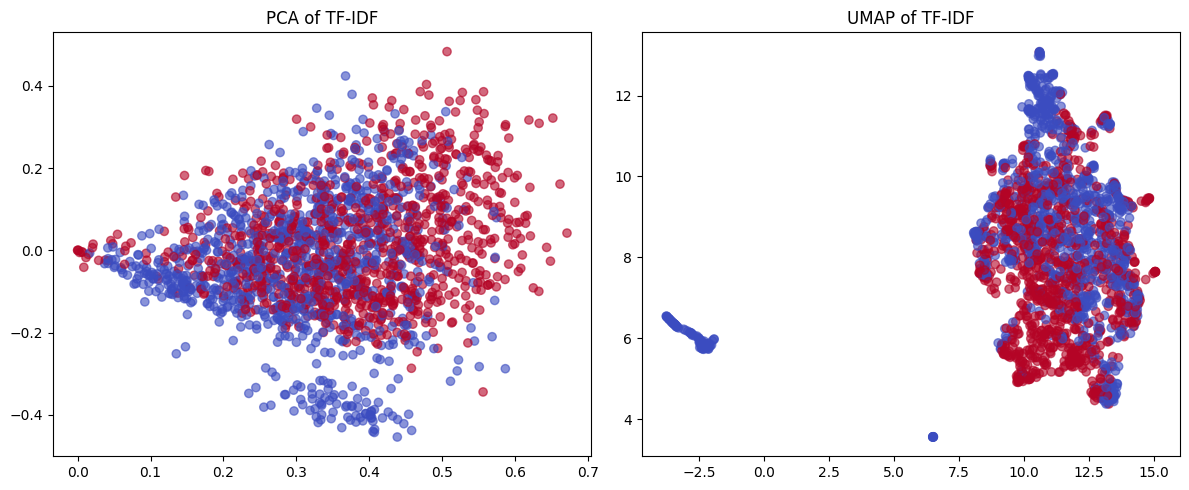

In [6]:
# Dimensionality reduction
svd = TruncatedSVD(50, random_state=42)
X_test_svd = svd.fit_transform(X_test_tfidf)

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_proj = umap_model.fit_transform(X_test_svd)

pca_2d = TruncatedSVD(2, random_state=42).fit_transform(X_test_tfidf)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[0].set_title("PCA of TF-IDF")
axs[1].scatter(umap_proj[:, 0], umap_proj[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[1].set_title("UMAP of TF-IDF")
plt.tight_layout()
plt.show()

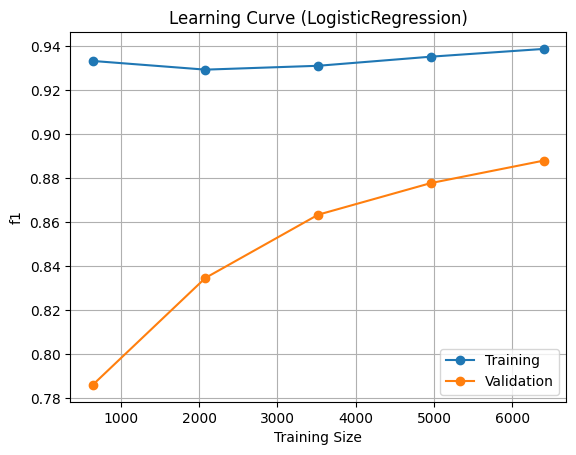

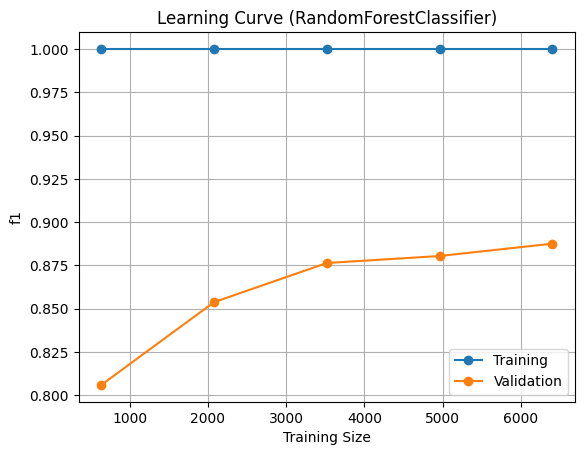

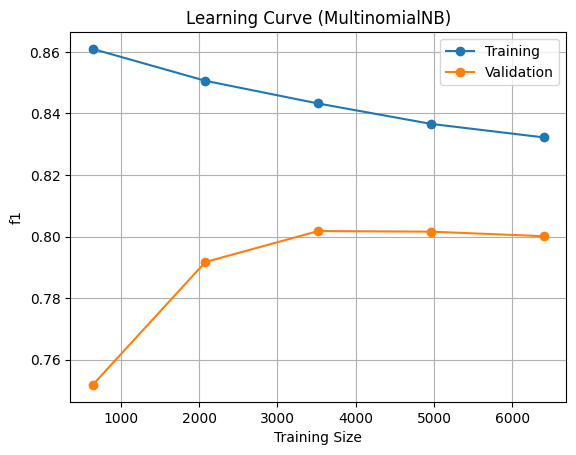

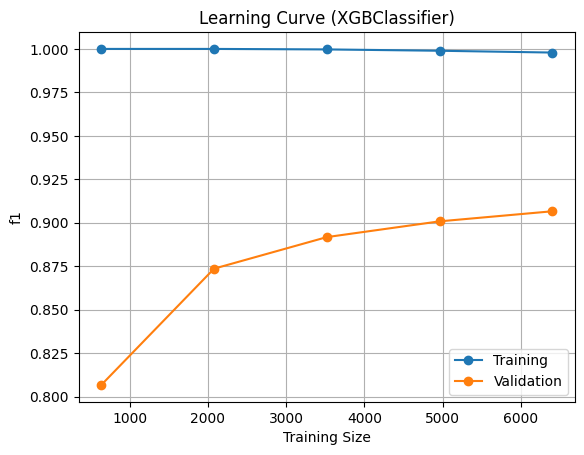

In [7]:
# Learning Curves
def plot_learning_curve(estimator, X, y, scoring='f1', cv=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation')
    plt.title(f'Learning Curve ({estimator.__class__.__name__})')
    plt.xlabel('Training Size')
    plt.ylabel(scoring)
    plt.legend()
    plt.grid()
    plt.show()

for name, model in models.items():
    plot_learning_curve(model, X_train_tfidf, y_train, scoring='f1')

Logistic Regression Brier score: 0.0917


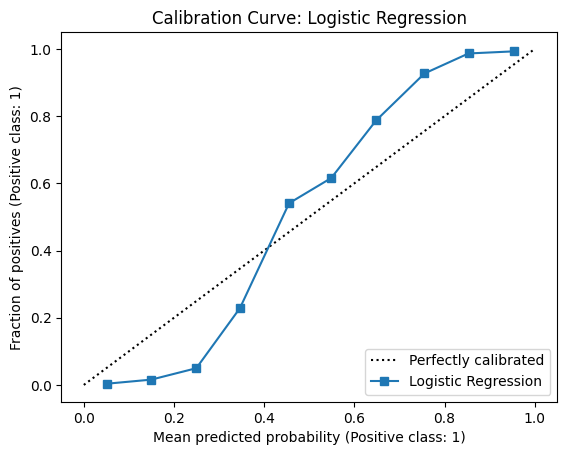

Random Forest Brier score: 0.1160


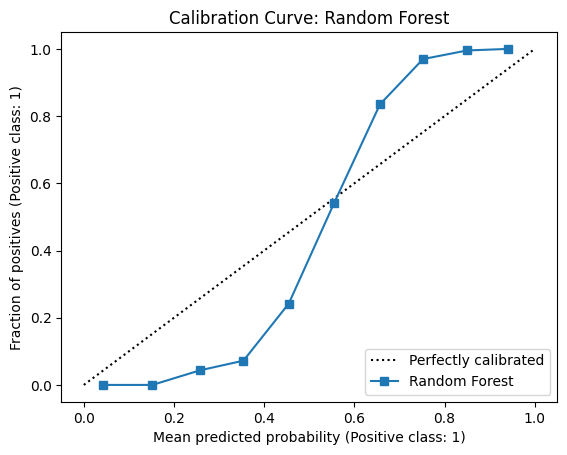

Naive Bayes Brier score: 0.1377


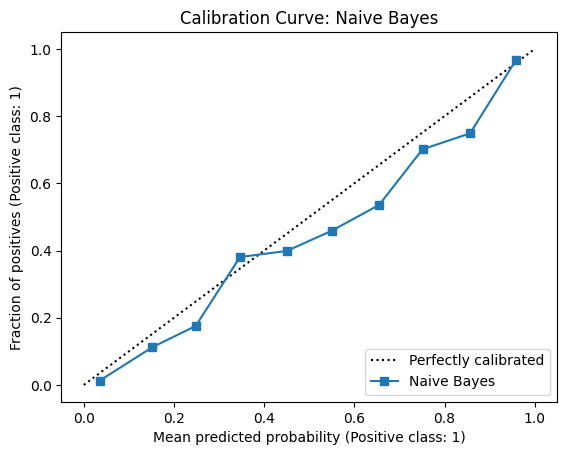

XGBoost Brier score: 0.0681


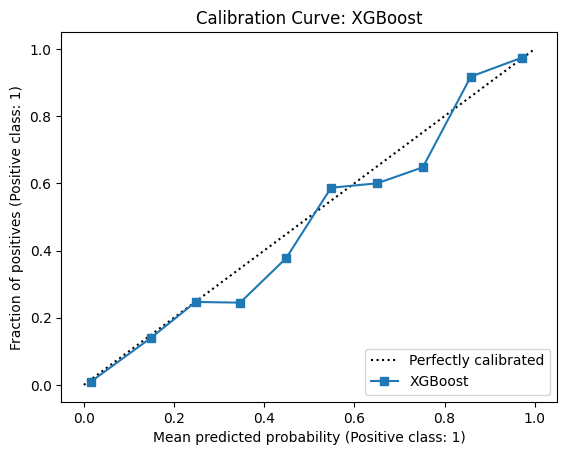

In [8]:
# Calibration Plots
from sklearn.calibration import calibration_curve

def plot_calibration_curve(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, y_prob)
    print(f"{name} Brier score: {brier:.4f}")
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, name=name)
    plt.title(f'Calibration Curve: {name}')
    plt.show()

for name, model in models.items():
    plot_calibration_curve(model, X_train_tfidf, y_train, X_test_tfidf, y_test, name)


--- SHAP Explanation for: Logistic Regression ---
SHAP Summary Plot:


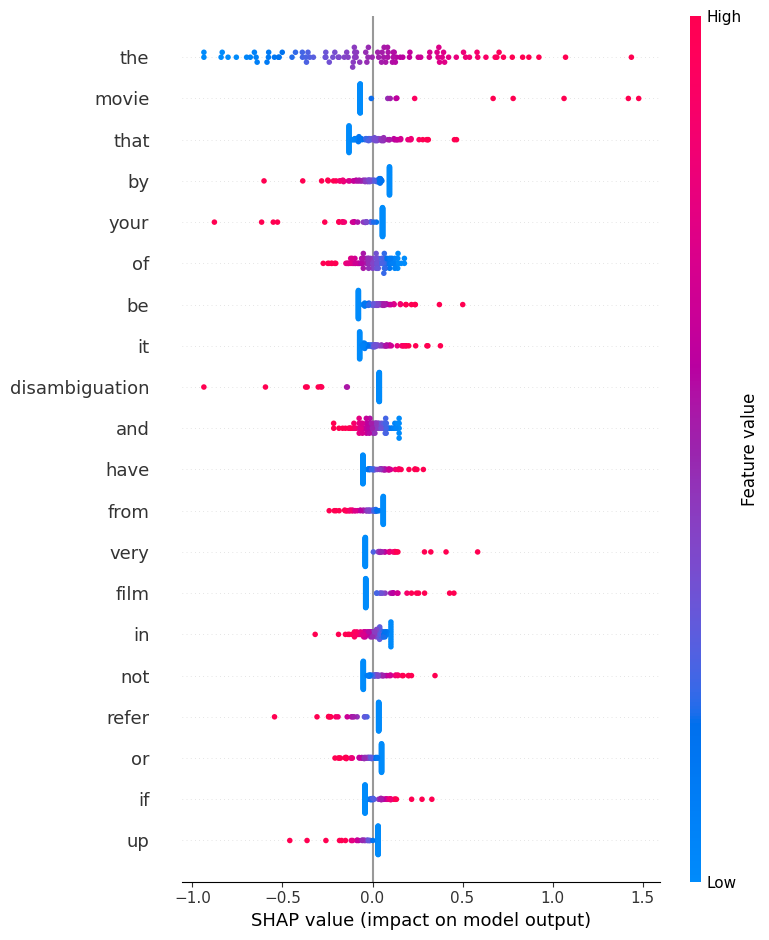


--- SHAP Explanation for: Random Forest ---
SHAP Summary Plot:


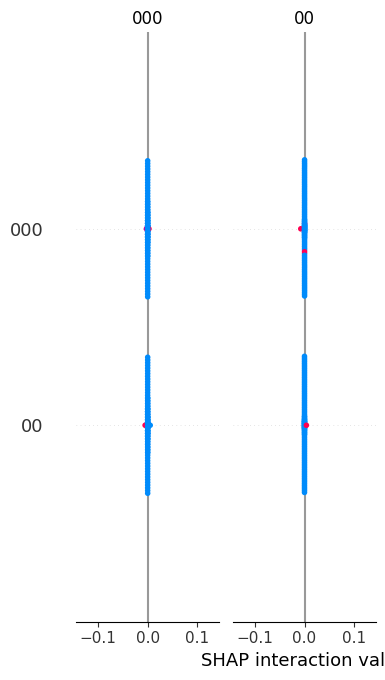


--- SHAP Explanation for: Naive Bayes ---
[Warning] Could not explain MultinomialNB with SHAP: The passed model is not callable and cannot be analyzed directly with the given masker! Model: MultinomialNB()

--- SHAP Explanation for: XGBoost ---
SHAP Summary Plot:


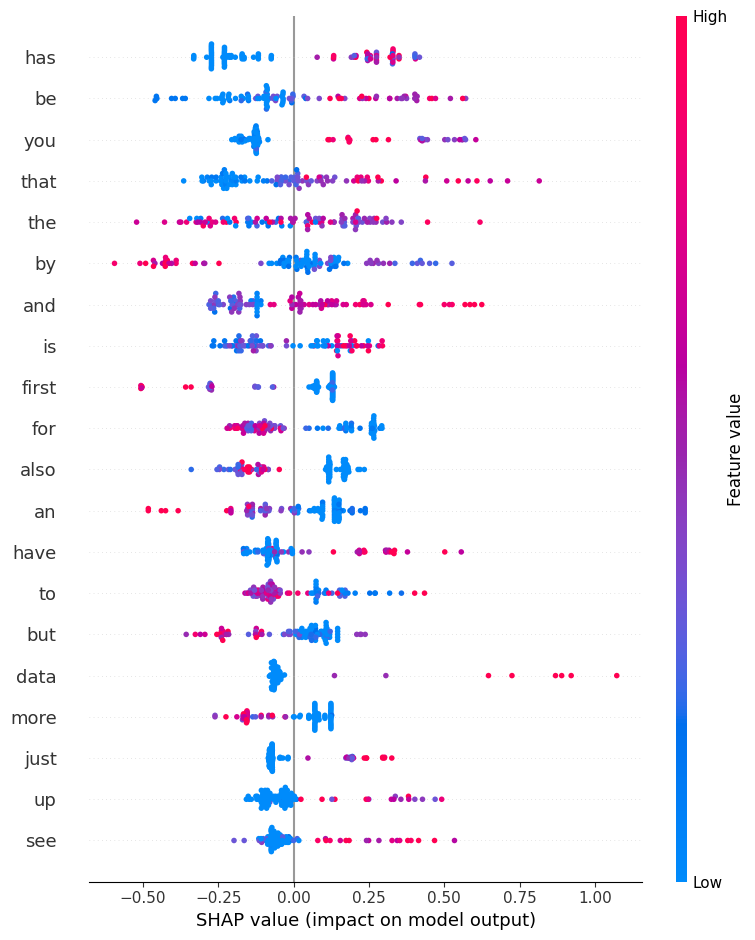

In [9]:
# --- SHAP Explainability Section ---

def explain_model_with_shap(model, X_sample, feature_names):
    # Ensure input is dense (SHAP tree explainer requires dense format)
    if hasattr(X_sample, "toarray"):
        X_sample = X_sample.toarray()

    try:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)

        print("SHAP Summary Plot:")
        shap.summary_plot(shap_values, features=X_sample, feature_names=feature_names)
    except Exception as e:
        print(f"[Warning] Could not explain {type(model).__name__} with SHAP: {e}")

# Apply SHAP to selected models
for name, model in models.items():
    print(f"\n--- SHAP Explanation for: {name} ---")
    try:
        explain_model_with_shap(model, X_test_tfidf[:100], tfidf_vectorizer.get_feature_names_out())
    except Exception as e:
        print(f"Failed for {name}: {e}")

In [10]:
cv_results = []

# Perform cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train_tfidf, y_train, scoring='f1', cv=5)
    mean_score = scores.mean()
    std_score = scores.std()

    print(f"{name} f1 scores: {scores}")
    print(f"Mean f1: {mean_score:.4f} (+/- {std_score:.4f})")

    cv_results.append({
        "Model": name,
        "Mean F1 Score": mean_score,
        "Std Dev": std_score,
        "Scores": scores
    })

# Create a DataFrame
from IPython.display import display, HTML

cv_df = pd.DataFrame(cv_results)

# Select columns to display
cv_display_df = cv_df[["Model", "Mean F1 Score", "Std Dev"]]

# Create a styled table with center alignment and formatting
styled_cv_df = (
    cv_display_df.style
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
    .set_properties(**{'text-align': 'center'})
    .format({
        "Mean F1 Score": "{:.4f}",
        "Std Dev": "{:.4f}"
    })
)

# Display title and table
display(HTML("<h3 style='text-align:center;'>Cross-Validation F1 Score Summary</h3>"))
display(styled_cv_df)

Logistic Regression f1 scores: [0.89252043 0.87603306 0.88959391 0.89633375 0.88602704]
Mean f1: 0.8881 (+/- 0.0069)
Random Forest f1 scores: [0.88429752 0.87396938 0.88783383 0.89306698 0.8972973 ]
Mean f1: 0.8873 (+/- 0.0080)
Naive Bayes f1 scores: [0.81627907 0.77328647 0.79346558 0.80921441 0.80830861]
Mean f1: 0.8001 (+/- 0.0153)
XGBoost f1 scores: [0.9118541  0.89279225 0.91187271 0.90657022 0.90998163]
Mean f1: 0.9066 (+/- 0.0072)


,Model,Mean F1 Score,Std Dev
0,Logistic Regression,0.8881,0.0069
1,Random Forest,0.8873,0.0080
2,Naive Bayes,0.8001,0.0153
3,XGBoost,0.9066,0.0072


In [11]:
# Extract accuracy, precision, recall, and ROC-AUC from the results
metrics_summary = []

for model_name, metrics in results.items():
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": metrics['accuracy'],
        "Precision": metrics['precision'],
        "Recall": metrics['recall'],
        "ROC-AUC": metrics['roc_auc']
    })

# Create a DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# Sort by Accuracy (or any other metric if preferred)
metrics_df = metrics_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Style the DataFrame with center alignment and 4-decimal formatting
styled_metrics_df = (
    metrics_df.style
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
    .set_properties(**{'text-align': 'center'})
    .format({
        "Accuracy": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "ROC-AUC": "{:.4f}"
    })
)

# Display the styled table
display(HTML("<h3 style='text-align:center;'>Model Evaluation Metrics</h3>"))
display(styled_metrics_df)

,Model,Accuracy,Precision,Recall,ROC-AUC
0,XGBoost,0.9075,0.8892,0.9310,0.9694
1,Random Forest,0.8865,0.8556,0.9300,0.9596
2,Logistic Regression,0.8830,0.8892,0.8750,0.9619
3,Naive Bayes,0.7905,0.7619,0.8450,0.8910


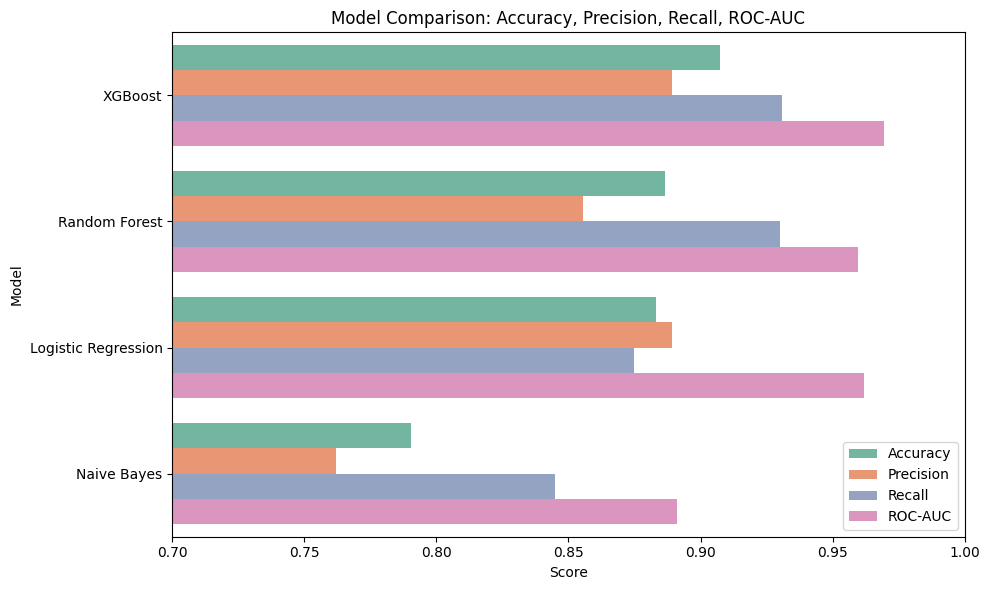

In [12]:
# Plotting side-by-side bars for visual comparison
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x="Score", y="Model", hue="Metric", palette="Set2")
plt.title("Model Comparison: Accuracy, Precision, Recall, ROC-AUC")
plt.xlabel("Score")
plt.xlim(0.7, 1.0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.calibration import CalibrationDisplay

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

In [15]:
def evaluate(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)  # For SVM
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # scale to [0,1]
    return y_pred, y_prob

In [16]:
def plot_learning_curve(estimator, X, y, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=5,
                                                          scoring=scoring,
                                                          train_sizes=np.linspace(0.1, 1.0, 5),
                                                          n_jobs=-1)
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label='CV Score')
    plt.title(f'Learning Curve ({estimator.__class__.__name__})')
    plt.xlabel('Training Examples')
    plt.ylabel(scoring)
    plt.legend()
    plt.grid()
    plt.show()

In [17]:
# === STEP 1: Classical Models - SVM, LightGBM, Voting Classifier ===
svm_model = SVC(probability=True)
lgbm_model = LGBMClassifier()

# Assuming models dict contains Logistic Regression and XGBoost already fitted/defined:
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
models.update({
    'SVM': svm_model,
    'LightGBM': lgbm_model,
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('xgb', models['XGBoost']),
            ('svm', svm_model)
        ],
        voting='soft'
    )
})

results = {}
predictions = []
probabilities = []
model_names = []

print("\n=== Classical NLP Models Evaluation ===\n")

for name in ['XGBoost', 'SVM', 'LightGBM', 'Voting Classifier']:
    print(f"Training and evaluating {name} ...")
    y_pred, y_prob = evaluate(models[name], X_train_tfidf, X_test_tfidf, y_train, y_test)
    predictions.append(y_pred)
    probabilities.append(y_prob)
    model_names.append(name)


=== Classical NLP Models Evaluation ===

Training and evaluating XGBoost ...
Training and evaluating SVM ...
Training and evaluating LightGBM ...
[LightGBM] [Info] Number of positive: 4000, number of negative: 4000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219822
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training and evaluating Voting Classifier ...


In [18]:
# === Metrics Table ===
metrics_data = []
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]
    metrics_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })

df_metrics = pd.DataFrame(metrics_data)

# Display styled table
display(HTML("<h3 style='text-align:center;'>Classical Models Evaluation Summary</h3>"))
numeric_cols = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
display(df_metrics.style.format({col: "{:.4f}" for col in numeric_cols}).set_properties(**{'text-align': 'center'}))

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,XGBoost,0.9075,0.8892,0.9310,0.9096,0.9694
1,SVM,0.9110,0.9135,0.9080,0.9107,0.9742
2,LightGBM,0.9125,0.8852,0.9480,0.9155,0.9752
3,Voting Classifier,0.9315,0.9235,0.9410,0.9321,0.9824


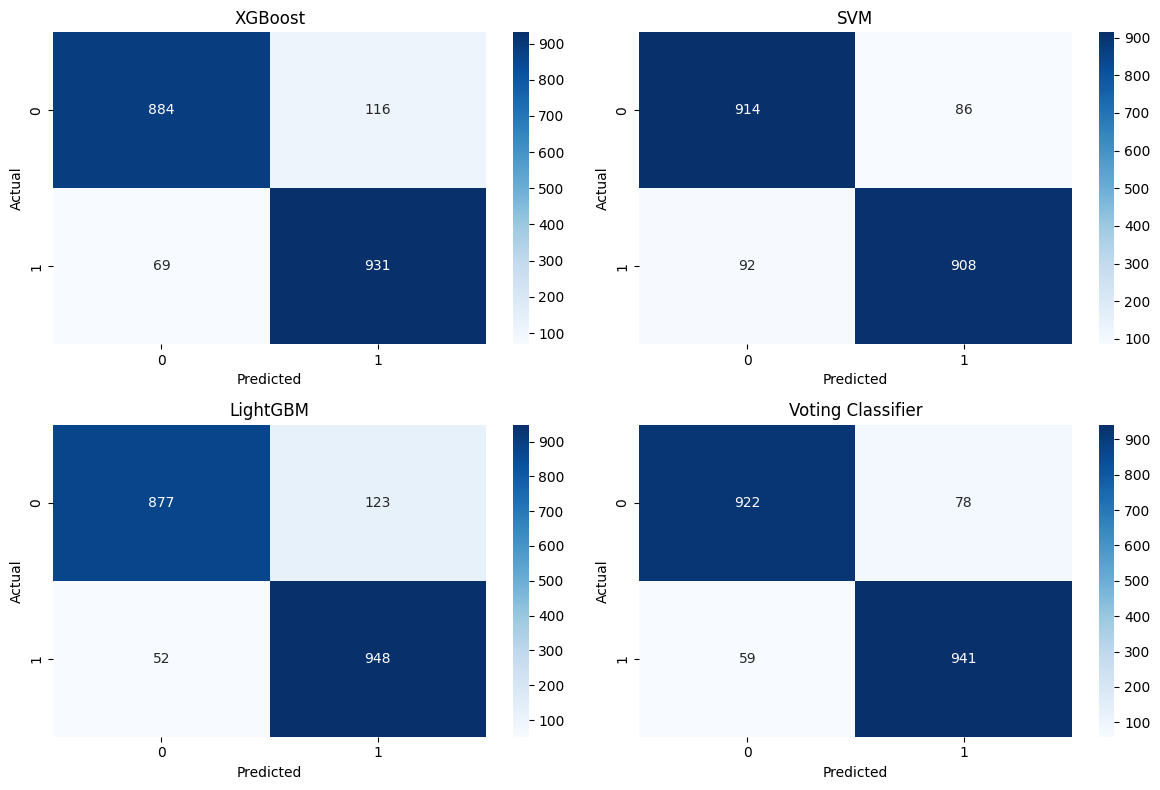

In [19]:
# === Confusion Matrices ===
from math import ceil

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, (name, y_pred) in enumerate(zip(model_names[:4], predictions[:4])):
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    
plt.tight_layout()
plt.show()

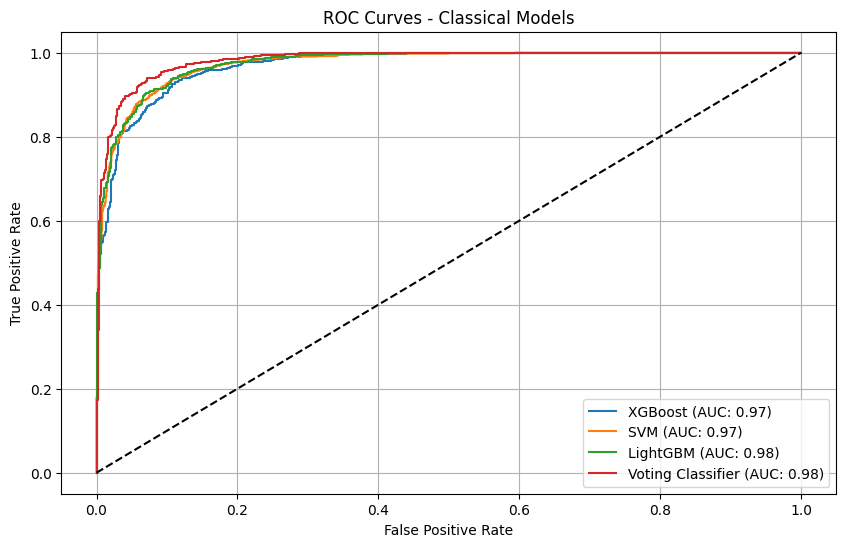

In [20]:
# === ROC Curves ===
plt.figure(figsize=(10, 6))
for name, y_prob in zip(model_names, probabilities):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Classical Models")
plt.legend()
plt.grid()
plt.show()

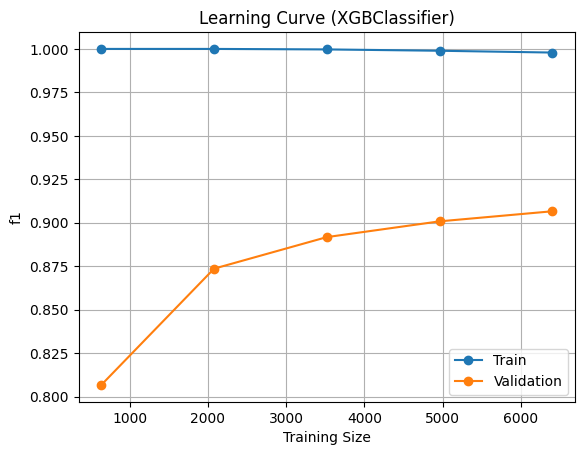

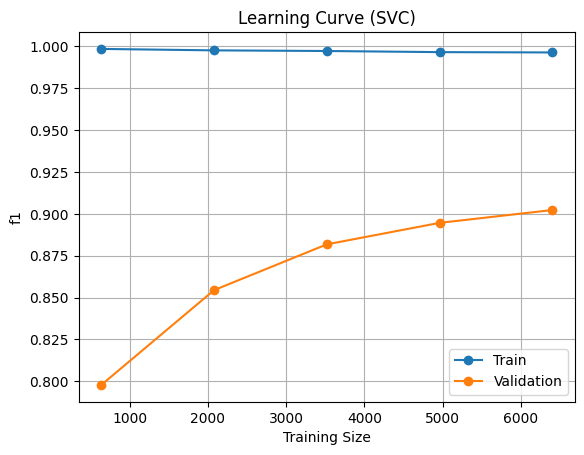

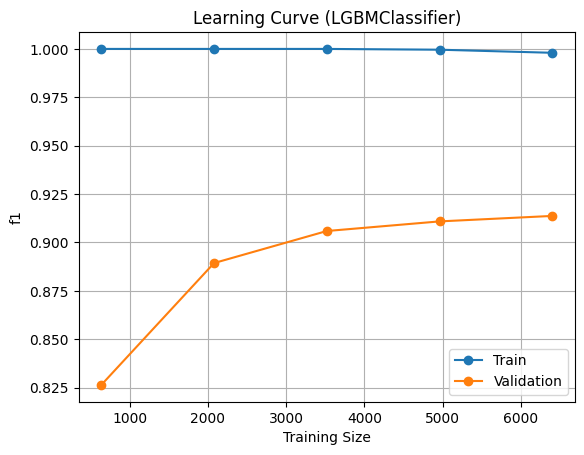

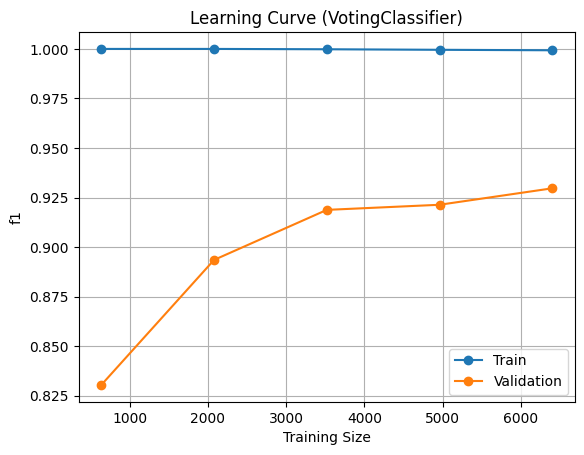

In [21]:
# --- Learning Curves (with suppressed output for all models including LightGBM) ---
import io
import contextlib

def plot_learning_curve_silent(estimator, X, y, scoring='accuracy'):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation')
    plt.title(f'Learning Curve ({estimator.__class__.__name__})')
    plt.xlabel('Training Size')
    plt.ylabel(scoring)
    plt.legend()
    plt.grid()
    plt.show()

# Suppress all output including LightGBM logs
for name, model in models.items():
    # Optional: Disable LightGBM verbosity if it's a LightGBM model
    if "lightgbm" in name.lower():
        try:
            model.set_params(verbosity=-1)
        except:
            pass

    f = io.StringIO()
    with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
        plot_learning_curve_silent(model, X_train_tfidf, y_train, scoring='f1')

<Figure size 1200x800 with 0 Axes>

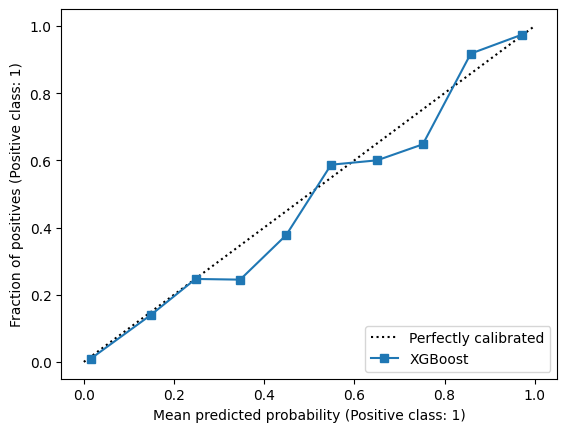

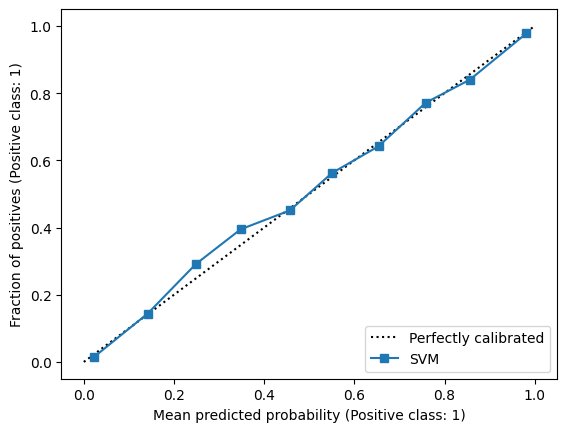

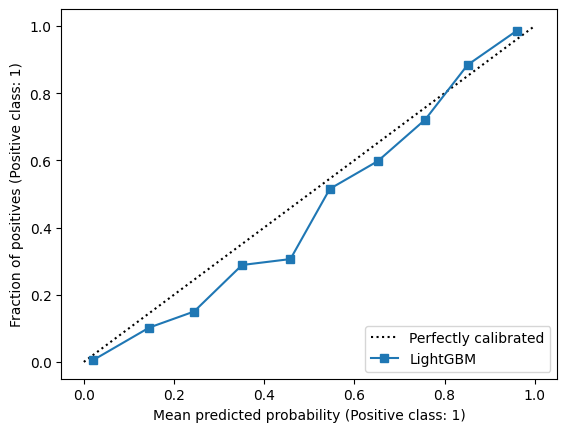

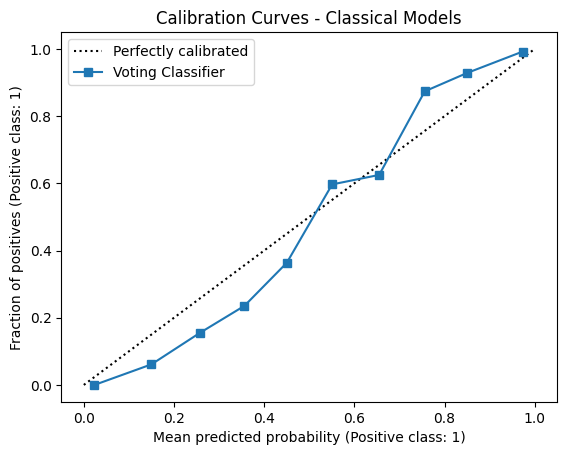

In [22]:
# === Calibration Curves ===
plt.figure(figsize=(12, 8))
for name, y_prob in zip(model_names, probabilities):
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, name=name)
plt.title("Calibration Curves - Classical Models")
plt.legend()
plt.show()

In [23]:
# === STEP 2: Preprocessing for Deep Learning ===
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 200

# Tokenize
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [24]:
# === STEP 3: CNN, LSTM, CNN-LSTM ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 128

In [25]:
# CNN model
model_cnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.fit(X_train_pad, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5


I0000 00:00:1749834452.831731      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749834452.832412      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1749834454.675221     152 service.cc:148] XLA service 0x6338f7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749834454.675949     152 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749834454.675972     152 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749834455.203920     152 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-13 17:07:37.547563: E external/local_xla/xla/service/slow_operation_ala

 44/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5786 - loss: 0.6820

I0000 00:00:1749834459.908812     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6700 - loss: 0.6187 - val_accuracy: 0.9087 - val_loss: 0.2199
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9420 - loss: 0.1716 - val_accuracy: 0.9250 - val_loss: 0.1774
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9821 - loss: 0.0715 - val_accuracy: 0.9250 - val_loss: 0.1811
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9975 - loss: 0.0208 - val_accuracy: 0.9212 - val_loss: 0.2150
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 0.0062 - val_accuracy: 0.9175 - val_loss: 0.2352


In [26]:
# LSTM model
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 557ms/step - accuracy: 0.7095 - loss: 0.5734 - val_accuracy: 0.9112 - val_loss: 0.2375
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - accuracy: 0.9382 - loss: 0.1863 - val_accuracy: 0.9225 - val_loss: 0.2591
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - accuracy: 0.9685 - loss: 0.1033 - val_accuracy: 0.8650 - val_loss: 0.3383
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 549ms/step - accuracy: 0.9699 - loss: 0.0994 - val_accuracy: 0.9112 - val_loss: 0.3270
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - accuracy: 0.9843 - loss: 0.0546 - val_accuracy: 0.8950 - val_loss: 0.3931


In [27]:
# CNN-LSTM model
model_cnn_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_lstm.fit(X_train_pad, y_train, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 70s 561ms/step - accuracy: 0.6613 - loss: 0.5904 - val_accuracy: 0.8938 - val_loss: 0.2987
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.9421 - loss: 0.1800 - val_accuracy: 0.9038 - val_loss: 0.2873
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 549ms/step - accuracy: 0.9724 - loss: 0.0924 - val_accuracy: 0.9050 - val_loss: 0.3040
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - accuracy: 0.9781 - loss: 0.0695 - val_accuracy: 0.9212 - val_loss: 0.3186
Epoch 5/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.9885 - loss: 0.0359 - val_accuracy: 0.9137 - val_loss: 0.3901


In [28]:
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from transformers import DistilBertTokenizerFast, DistilBertModel
import os

# === Force CPU ===
device = torch.device("cpu")

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

# === Dataset Class ===
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True,
                                   max_length=max_len, return_tensors="pt")
        self.labels = torch.tensor(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# === Tokenizer & Model ===
max_len = 128
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# === BERT Classifier Model ===
class BERTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :]
        return self.linear(self.dropout(cls_output)).squeeze(-1)

# === DataLoaders ===
train_dataset = BERTDataset(X_train, y_train, bert_tokenizer, max_len)
test_dataset = BERTDataset(X_test, y_test, bert_tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# === Model, Optimizer, Loss (on CPU) ===
model = BERTClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.BCEWithLogitsLoss()  # More stable with logits

# === Training Loop ===
model.train()
for epoch in range(2):
    total_loss = 0
    for batch in tqdm(train_loader):
        inputs, labels = batch
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Evaluation (optional) ===
model.eval()
preds = []
actuals = []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs)
        preds.extend((probs > 0.5).int().tolist())
        actuals.extend(labels.tolist())

from sklearn.metrics import classification_report
print("\n=== Classification Report ===")
print(classification_report(actuals, preds))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1000/1000 [50:33<00:00,  3.03s/it]


Epoch 1 - Loss: 144.7285


100%|██████████| 1000/1000 [50:44<00:00,  3.04s/it]


Epoch 2 - Loss: 34.1291

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1000
           1       0.96      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [29]:
# === STEP 5: Evaluation of DL Models ===
def evaluate_dl_model_keras(model, X_test, y_test):
    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)
    return y_pred, y_prob

print("\n=== Deep Learning Models Evaluation ===\n")

dl_model_names = ['CNN', 'LSTM', 'CNN-LSTM']
dl_models = [model_cnn, model_lstm, model_cnn_lstm]

dl_predictions = []
dl_probabilities = []

for name, model in zip(dl_model_names, dl_models):
    y_pred, y_prob = evaluate_dl_model_keras(model, X_test_pad, y_test)
    dl_predictions.append(y_pred)
    dl_probabilities.append(y_prob)
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))


=== Deep Learning Models Evaluation ===

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN Results:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step
LSTM Results:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1000
           1       0.92      0.88      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.91      0.91      0.90      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step
CNN-LSTM Results:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1000
           1       0.93      

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# === BERT Evaluation Metrics ===
bert_preds_tensor = torch.tensor(preds)
bert_probs_tensor = torch.tensor(preds)  # Already thresholded at 0.5

bert_accuracy = accuracy_score(actuals, preds)
bert_precision = precision_score(actuals, preds)
bert_recall = recall_score(actuals, preds)
bert_f1 = f1_score(actuals, preds)
bert_auc = roc_auc_score(actuals, preds)  # Use logits or probs if available

# === Deep Learning Models Metrics ===
dl_metrics = []
for name, y_pred, y_prob in zip(dl_model_names, dl_predictions, dl_probabilities):
    dl_metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    })

# === Classical Models Metrics Already Exist in df_metrics ===
# Add DL + BERT to it
bert_row = {
    'Model': 'BERT',
    'Accuracy': bert_accuracy,
    'Precision': bert_precision,
    'Recall': bert_recall,
    'F1': bert_f1,
    'ROC-AUC': bert_auc
}

final_df = pd.concat([
    df_metrics,
    pd.DataFrame(dl_metrics),
    pd.DataFrame([bert_row])
], ignore_index=True)

# === Display All Metrics Together ===
display(HTML("<h3 style='text-align:center;'>All Models Performance Summary</h3>"))
styled_final = final_df.style.format({col: "{:.4f}" for col in numeric_cols}).set_properties(**{'text-align': 'center'})
display(styled_final)

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,XGBoost,0.9075,0.8892,0.9310,0.9096,0.9694
1,SVM,0.9110,0.9135,0.9080,0.9107,0.9742
2,LightGBM,0.9125,0.8852,0.9480,0.9155,0.9752
3,Voting Classifier,0.9315,0.9235,0.9410,0.9321,0.9824
4,CNN,0.9205,0.9226,0.9180,0.9203,0.9754
5,LSTM,0.9050,0.9228,0.8840,0.9030,0.9607
6,CNN-LSTM,0.9150,0.9323,0.8950,0.9133,0.9691
7,BERT,0.9775,0.9631,0.9930,0.9778,0.9775


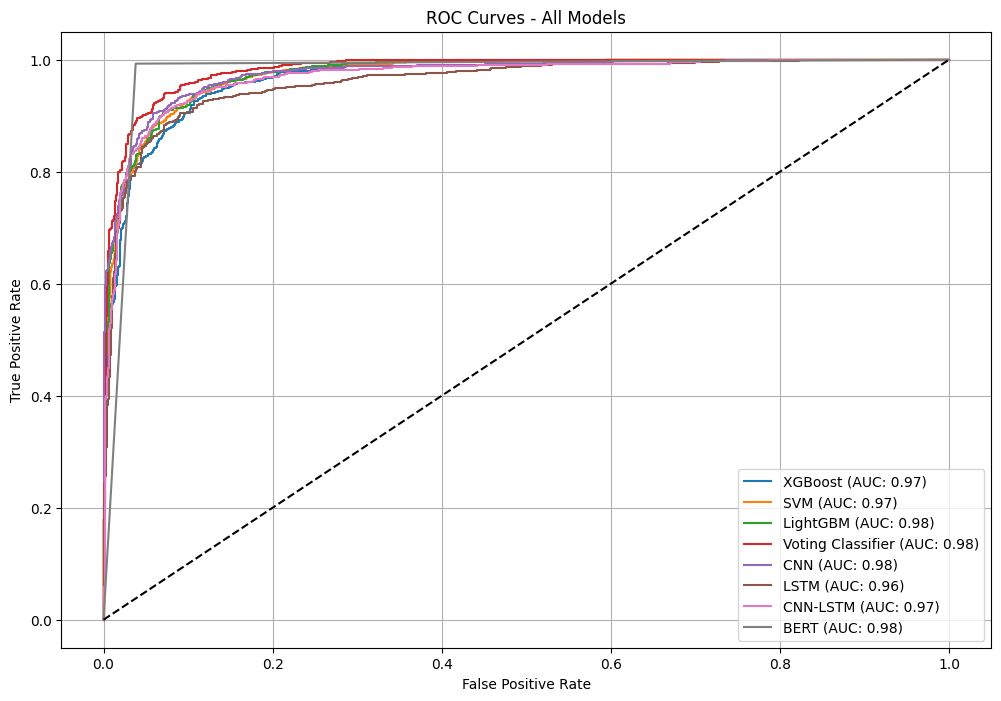

In [31]:
plt.figure(figsize=(12, 8))

# Classical
for name, y_prob in zip(model_names, probabilities):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.2f})')

# Deep Learning
for name, y_prob in zip(dl_model_names, dl_probabilities):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.2f})')

# BERT
bert_fpr, bert_tpr, _ = roc_curve(y_test, preds)
bert_auc = roc_auc_score(y_test, preds)
plt.plot(bert_fpr, bert_tpr, label=f'BERT (AUC: {bert_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.grid()
plt.show()

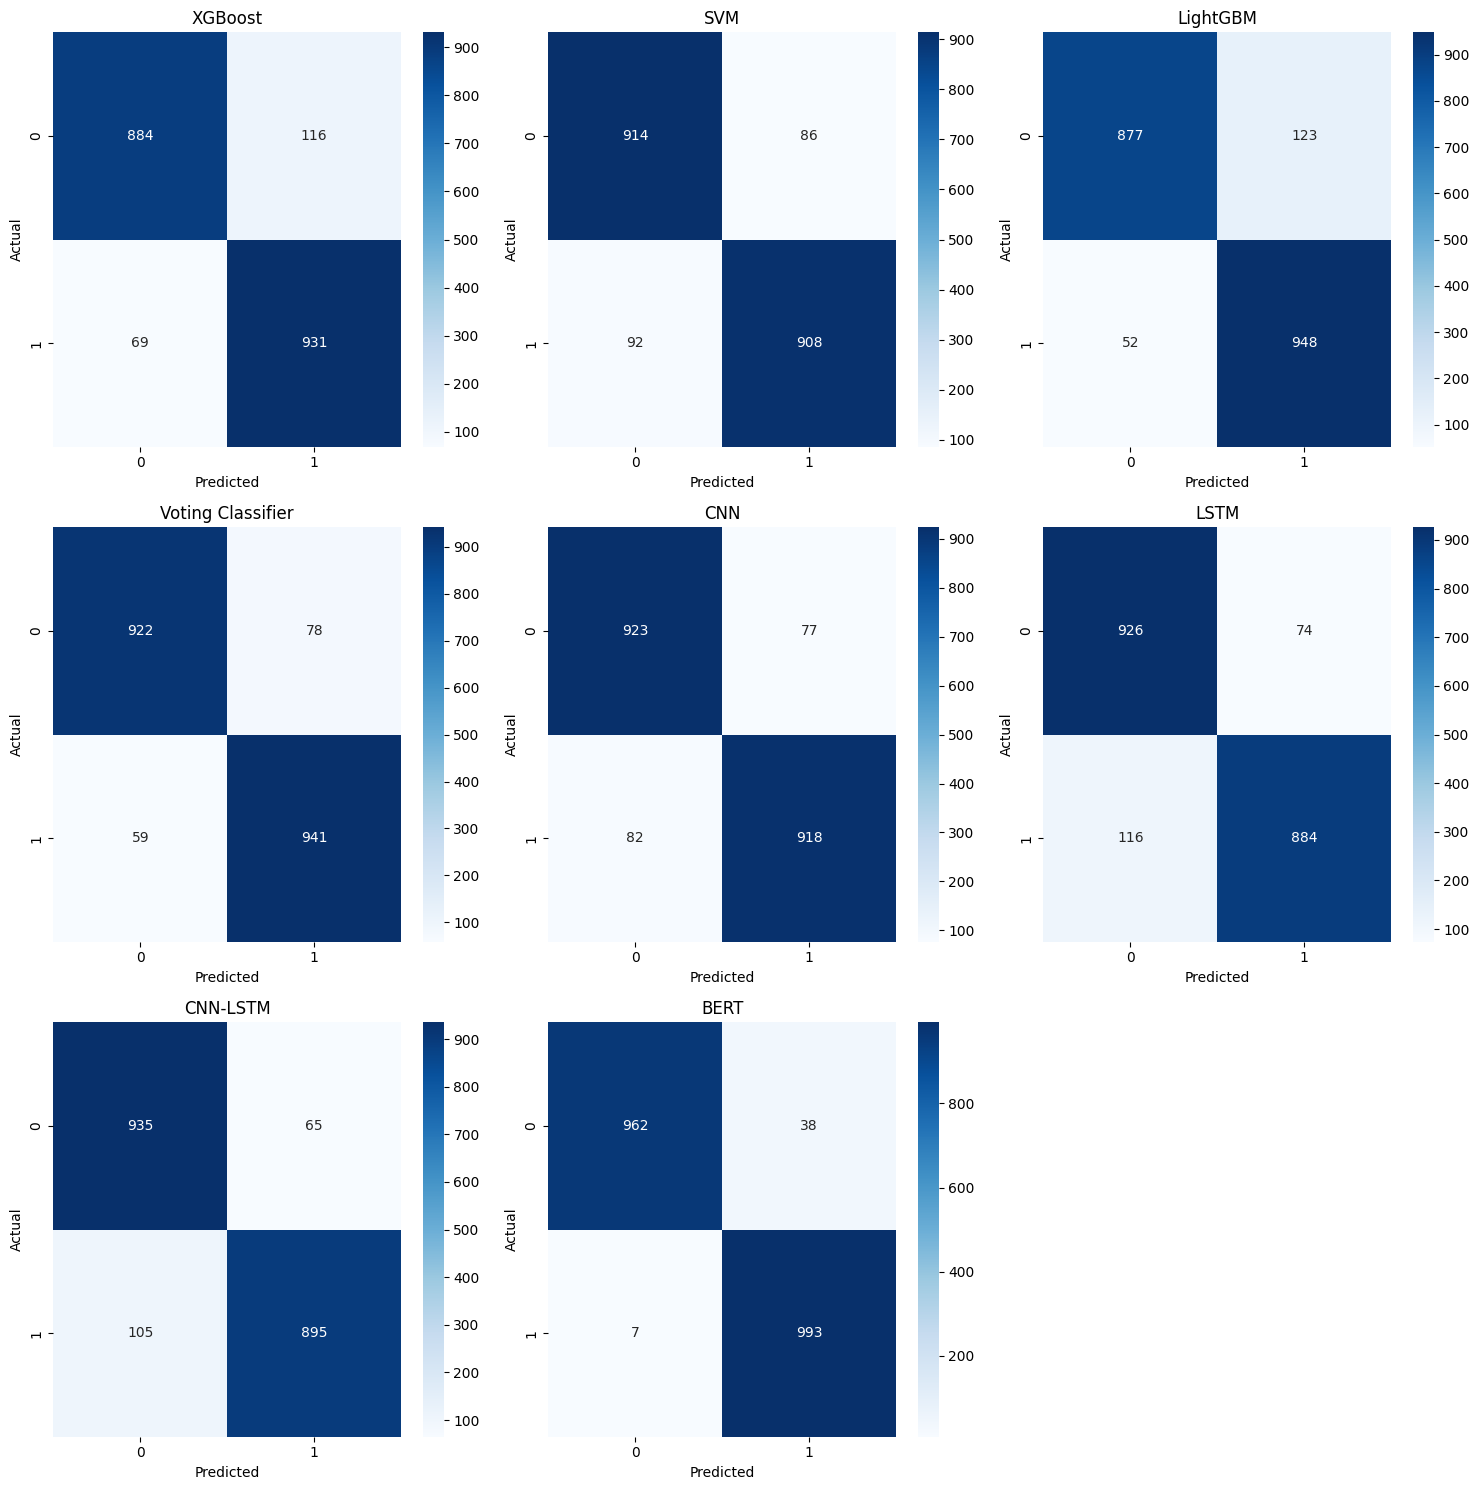

In [32]:
from math import ceil

all_names = model_names + dl_model_names + ['BERT']
all_preds = predictions + dl_predictions + [preds]

rows = ceil(len(all_preds) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, (name, pred) in enumerate(zip(all_names, all_preds)):
    sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()